<a href="https://colab.research.google.com/github/sauravakolia/Fastai2/blob/master/05_anneal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!git clone https://github.com/sauravakolia/Fastai2.git

Cloning into 'Fastai2'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 92 (delta 49), reused 19 (delta 8), pack-reused 0
Unpacking objects: 100% (92/92), done.


In [3]:
# %cd "/content/Fastai2/"
import sys
sys.path.append('/content/Fastai2/')

In [4]:
!pip install fire

     |████████████████████████████████| 81kB 2.5MB/s 
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111005 sha256=d7b0ea1eb6aff4b36a14269ca4314d5f39a2f3b68eede214bad3e7445c4a7c42
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
Successfully built fire


In [5]:
#export
from exp.nb_04 import *

## Initial setup

In [6]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [7]:
data=DataBunch(*get_dls(train_ds,valid_ds,bs),c)

In [8]:
#export
def create_learner(model_func,loss_func,data):
  return Learner(*model_func(data),loss_func,data)

In [9]:
learn=create_learner(get_model,loss_func,data)

In [10]:
run=Runner([AvgStatsCallback([accuracy])])
run.fit(3,learn)

train: [0.670916875, tensor(0.8039)]
valid: [0.3160788330078125, tensor(0.9105)]
train: [0.2989583984375, tensor(0.9125)]
valid: [0.2440197509765625, tensor(0.9307)]
train: [0.24214064453125, tensor(0.9308)]
valid: [0.2040796875, tensor(0.9422)]


In [11]:
#export
def get_model_func(lr=0.5):return partial(get_model,lr=lr)

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

In [12]:
#export
class Recorder(Callback):
  def begin_fit(self):
    self.lrs,self.losses=[],[]
  
  def after_batch(self):
    if not self.in_train:return
    self.lrs.append(self.opt.param_groups[-1]['lr'])
    self.losses.append(self.loss.detach().cpu())
  
  def plot_lr(self):
    plt.plot(self.lrs)
  
  def plot_losses(self):
    plt.plot(self.losses)

class ParamScheduler(Callback):
  _order=1
  def __init__(self,pname,sched_func):
    self.pname,self.sched_func=pname,sched_func
  
  def set_param(self):
    for pg in self.opt.param_groups:
      pg[self.pname]=self.sched_func(self.n_epochs/self.epochs)
  
  def begin_batch(self):
    if self.in_train : self.set_param()


Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

In [13]:
def sched_lin(start,end):
  def _inner(start,end,pos):return start +pos*(end-start)
  return partial(_inner,start,end)


In [14]:
lin=sched_lin(1,2)


In [15]:
lin(0.1)

1.1

In [16]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [17]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

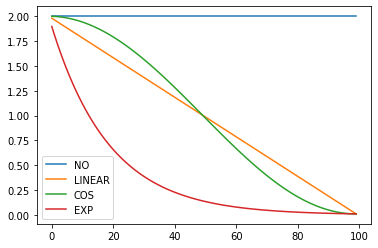

In [18]:
annealings = "NO LINEAR COS EXP".split()

a=torch.arange(0,100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]

for fn, t in zip(fns, annealings):
  f = fn(2, 1e-2)
  plt.plot(a, [f(o) for o in p], label=t)
plt.legend();




[link text](https://)In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [19]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        if idx == 2: idx = 1
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [20]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

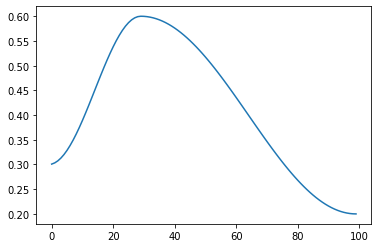

In [21]:
plt.plot(a, [sched(o) for o in p])

We can use it for training quite easily...

In [22]:
cbfs=[Recorder,
      partial(AvgStatsCallback,accuracy),
      partial(ParamScheduler,'lr',sched)]


In [23]:
learn=create_learner(get_model_func(0.3),loss_func,data)
run=Runner(cb_funcs=cbfs)

In [24]:
run.fit(3,learn)

train: [0.77353234375, tensor(0.7882)]
valid: [0.3186359130859375, tensor(0.9098)]
train: [0.29495728515625, tensor(0.9138)]
valid: [0.2339066650390625, tensor(0.9336)]
train: [0.23605974609375, tensor(0.9324)]
valid: [0.2116033203125, tensor(0.9390)]


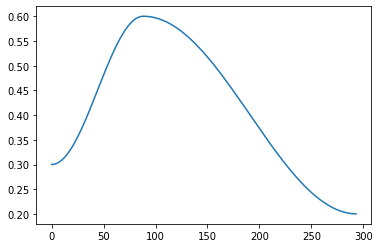

In [25]:
run.recorder.plot_lr()

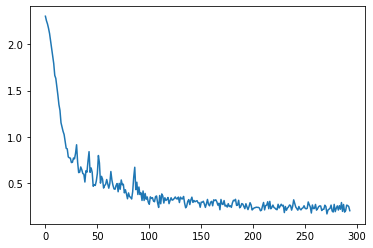

In [28]:
run.recorder.plot_losses()

## Export

In [29]:
%cd "/content/Fastai2/"

/content/Fastai2


In [30]:
!python notebook2script.py 05_anneal.ipynb

Traceback (most recent call last):
  File "notebook2script.py", line 74, in <module>
    if __name__ == '__main__': fire.Fire(notebook2script)
  File "/usr/local/lib/python3.6/dist-packages/fire/core.py", line 138, in Fire
    component_trace = _Fire(component, args, parsed_flag_args, context, name)
  File "/usr/local/lib/python3.6/dist-packages/fire/core.py", line 468, in _Fire
    target=component.__name__)
  File "/usr/local/lib/python3.6/dist-packages/fire/core.py", line 672, in _CallAndUpdateTrace
    component = fn(*varargs, **kwargs)
  File "notebook2script.py", line 46, in notebook2script
    if not allFiles: notebook2scriptSingle(fname)
  File "notebook2script.py", line 57, in notebook2scriptSingle
    main_dic = json.load(open(fname,'r',encoding="utf-8"))
FileNotFoundError: [Errno 2] No such file or directory: '05_anneal.ipynb'
